This notebook shows how the pretrained weights for the [Rice Leaf Diseases: Implementing a Custom Model - Part 2](rice_image_classification_2.ipynb) notebook.  The weights were produced by fitting the same model architecture [1] (except for the classifier layer) to the "Plant Leaves" dataset from [2]:

    https://data.mendeley.com/datasets/hb74ynkjcn/1
    dl: https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip

> Principally, the complete set of images have been classified among two classes
> i.e. healthy and diseased. First, the acquired images are classified and labeled
> conferring to the plants. The plants were named ranging from P0 to P11. Then the
> entire dataset has been divided among 22 subject categories ranging from 0000 to
> 0022. The classes labeled with 0000 to 0011 were marked as a healthy class and
> ranging from 0012 to 0022 were labeled diseased class.

[1]: Wick, C. & Puppe, F. Leaf Identification Using a Deep Convolutional Neural Network. arXiv:1712.00967 [cs] (2017).

[2]: CHOUHAN, Siddharth Singh; Kaul, Ajay; SINGH, UDAY PRATAP; Madhav Institute of Technology & Science  (2019), “A Database of Leaf Images: Practice towards Plant Conservation with Plant Pathology”, Mendeley Data, V1, doi: 10.17632/hb74ynkjcn.1 <https://data.mendeley.com/datasets/hb74ynkjcn/1>

In [1]:
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.metrics as metrics


## First, obtain the data and create a CSV ground truth file for easy use later:

First, download the dataset from:

<https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip>

The directory structure has the plant name at top level:

    Plant Name (PX)/
    diseased/
        ... files  
    healthy/
        ... files    

In [ ]:
# Set the following path to wherever you downloaded the Plant Leaves data:
dataset_local = "plant_leaves"
class_dirs = [path for path in os.listdir(dataset_local) if os.path.isdir(os.path.join(dataset_local, path))]
class_names = class_dirs
print(class_dirs)

The following code will extract the information we need (plant names, class numbers and a disease indicator flat) from the directory structure and file naming scheme.

In [ ]:
plant_names     = []
image_names     = []
class_numbers   = []
plant_numbers   = []
disease_classes = []
for c_name in class_dirs:
    for d_class in ['diseased', 'healthy']:
        img_path = os.path.join(c_name, d_class)
        try:
            images = os.listdir(os.path.join(dataset_local, img_path))
            image_names.extend([os.path.join(img_path, img_name) for img_name in images])
            new_class_numbers = [int(img_name[:4]) for img_name in images]
            class_numbers.extend(new_class_numbers)
            disease_classes.extend([int(d_class == 'diseased') for _ in images])
            plant_numbers.extend([(c_no - 1) % 11 + 1 for c_no in new_class_numbers])
            plant_names.extend([c_name for _ in images])
        except FileNotFoundError:
            print(f"No listing for \"{d_class}\" in plant \"{c_name}\".")
            continue

Now we can create a DataFrame containing that information, along with a path to each file.  This makes it easy to use "flow_from_dataframe()" later during training and evaluation.

In [ ]:
df = pd.DataFrame({
    'plant_no': plant_numbers,
    'plant_name': plant_names,
    'class_no': class_numbers,
    'diseased_flag': disease_classes,
    'image_path': image_names,
})

# Show a bit of what the data look like, and save the DataFrame to a CSV file for later use.

print(df.sample(n=10))
df = df.sort_values(by=['class_no'])
df.to_csv("plant_leaves_gt.csv", index=False)

## Build the classifier model for solving the Plant Leaves problem

In [2]:
def build_leaf_classifier_model(input_shape=(256,256,3), n_classes=3):
    '''
    This function builds a Keras CNN similar to the one described in Wick et al. (2017).
    '''
    lrelu = keras.layers.LeakyReLU()
    input = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(40, (3,3), activation=lrelu, padding='same', name="conv1")(input)
    x = keras.layers.MaxPool2D((2,2), name='max_pool1')(x)
    x = keras.layers.Conv2D(40, (4,4), activation=lrelu, padding='same', name='conv2')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool2')(x)
    x = keras.layers.Conv2D(80, (4,4), activation=lrelu, padding='same', name='conv3')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool3')(x)
    x = keras.layers.Conv2D(160, (4,4), activation=lrelu, padding='same', name='conv4')(x)
    x = keras.layers.MaxPool2D((2,2), name='max_pool4')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(500, activation=lrelu)(x)
    x = keras.layers.Dropout(0.20)(x)
    x = keras.layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(inputs=input, outputs=x)

In [3]:
def evaluate(model, val_gen):
    batches = [list(next(val_gen))[0] for idx in range(len(val_gen))]
    gt = []
    for batch in batches:
        gt.extend(batch)
    gt = np.array(gt)
    predictions = model._autoencoder.predict(gt)
    # for i in range(3):
    #     side_by_side(gt[i], predictions[i])
    mse = keras.metrics.MeanSquaredError()
    mse.update_state(gt, predictions)
    return mse.result().numpy()

In [4]:
# Load the plant leaves dataset ground truth.  We will use it to pre-train the model.
plant_leaves_data_dir = "plant_leaves"
plant_leaves_gt = pd.read_csv("plant_leaves_gt.csv", index_col=False)
# Create a more model-friendly plant name/class scheme:
plant_leaves_gt['class_name'] = [plant['plant_name'].split()[0] + {0: "_healthy", 1: "_diseased"}[plant['diseased_flag']] for _, plant in plant_leaves_gt.iterrows()]
image_classes = list(plant_leaves_gt['class_name'].unique())
# Now, the class is a numeric representation and class_name is a string representation.
plant_leaves_gt.head()

,plant_no,plant_name,class_no,diseased_flag,image_path,class_name
0,1,Mango (P0),1,0,Mango (P0)/healthy/0001_0016.JPG,Mango_healthy
1,1,Mango (P0),1,0,Mango (P0)/healthy/0001_0098.JPG,Mango_healthy
2,1,Mango (P0),1,0,Mango (P0)/healthy/0001_0048.JPG,Mango_healthy
3,1,Mango (P0),1,0,Mango (P0)/healthy/0001_0068.JPG,Mango_healthy
4,1,Mango (P0),1,0,Mango (P0)/healthy/0001_0155.JPG,Mango_healthy


In [5]:
sss = StratifiedShuffleSplit(1, test_size=0.10, random_state=2021)
train_indices, test_indices = list(sss.split(plant_leaves_gt.values, plant_leaves_gt['class_no'].values))[0]
print(f"Training set has {train_indices.shape[0]} samples.")
print(f"Test set has {test_indices.shape[0]} samples.")

Training set has 4051 samples.
Test set has 451 samples.


In [6]:
# Create the model -- notice the number of classes should 
# be 22 for this problem.
leaf_model = build_leaf_classifier_model(n_classes=22)

In [7]:
# Declare the generators and some simple augmentations for training
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    width_shift_range=0.20,
    height_shift_range=0.10,
    zoom_range=0.2,
    brightness_range=(0.5, 1.25),
)

In [13]:
leaf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
BATCH_SIZE = 32
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="weights/lm-pre-ckpt_{epoch:02d}-{val_loss:.2f}.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)]
history = leaf_model.fit(
    train_generator.flow_from_dataframe(
        plant_leaves_gt.iloc[train_indices,:],
        directory=plant_leaves_data_dir,
        x_col = "image_path",
        y_col = "class_name",
        target_size = (256,256),
        classes = image_classes,
        shuffle = True,
        seed = 2021,
        batch_size=BATCH_SIZE,
    ),
    validation_data=test_generator.flow_from_dataframe(
        plant_leaves_gt.iloc[test_indices,:],
        directory=plant_leaves_data_dir,
        x_col = "image_path",
        y_col = "class_name",
        target_size = (256,256),
        classes = image_classes,
        shuffle = False,
        seed = 2021,
        batch_size=BATCH_SIZE,
    ),
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Found 4051 validated image filenames belonging to 22 classes.
Found 451 validated image filenames belonging to 22 classes.
Epoch 2/30
127/127 [==============================] - 1084s 9s/step - loss: 1.9603 - acc: 0.3794 - val_loss: 1.5049 - val_acc: 0.5455
Epoch 3/30
127/127 [==============================] - 1090s 9s/step - loss: 1.7128 - acc: 0.4591 - val_loss: 1.3071 - val_acc: 0.5588
Epoch 4/30
127/127 [==============================] - 1083s 9s/step - loss: 1.4757 - acc: 0.5246 - val_loss: 1.1445 - val_acc: 0.6297
Epoch 5/30
127/127 [==============================] - 4075s 32s/step - loss: 1.2641 - acc: 0.5912 - val_loss: 1.5759 - val_acc: 0.4945
Epoch 6/30
127/127 [==============================] - 1082s 9s/step - loss: 1.1414 - acc: 0.6361 - val_loss: 1.2341 - val_acc: 0.5388
Epoch 7/30
127/127 [==============================] - 1077s 8s/step - loss: 1.0695 - acc: 0.6492 - val_loss: 0.9021 - val_acc: 0.7029
Epoch 8/30
127/127 [==============================] - 1084s 9s/step - lo

In [14]:
import joblib
joblib.dump(history.history, "lm-pre-fit_history.joblib.gz")

['lm-pre-fit_history.joblib.gz']

In [17]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Training Loss / Accuracy')
    plt.ylabel('loss/accuracy')
    plt.xlabel('epoch')
    plt.ylim((0,2.0))
    plt.legend(['train loss', 'val loss', 'train acc', 'val acc'], loc='upper left')
    plt.show()


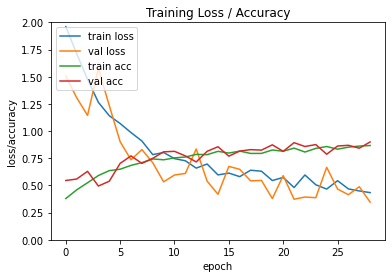

In [18]:
plot_history(history)

In [19]:
best_weights = "weights/lm-pre-ckpt_30-0.35.h5"